### Stock Market Prediction And Forecasting Using Stacked LSTM

In [1]:
import pandas_datareader as pdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pdr.get_data_tiingo('QQQ', api_key='6cbca726c5a80908ade0f47c65ec52fe126c0be4')

/usr/local/lib/python3.7/dist-packages/pandas_datareader/tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  return pd.concat(dfs, self._concat_axis)


In [3]:
df.to_csv('AAPL.csv')

In [4]:
df=pd.read_csv('AAPL.csv')

In [5]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,QQQ,2017-05-12 00:00:00+00:00,138.60,138.63,138.23,138.37,19738629,133.583240,133.612154,133.226632,133.361565,19738629,0.0,1.0
1,QQQ,2017-05-15 00:00:00+00:00,139.04,139.12,138.53,138.63,20481327,134.007314,134.084418,133.515773,133.612154,20481327,0.0,1.0
2,QQQ,2017-05-16 00:00:00+00:00,139.62,139.64,138.99,139.36,21785994,134.566320,134.585596,133.959123,134.315731,21785994,0.0,1.0
3,QQQ,2017-05-17 00:00:00+00:00,136.07,138.77,136.05,138.55,55642178,131.144816,133.747086,131.125539,133.535050,55642178,0.0,1.0
4,QQQ,2017-05-18 00:00:00+00:00,137.26,137.72,135.87,136.06,41319882,132.291742,132.735092,130.952055,131.135177,41319882,0.0,1.0


In [6]:
df.shape

(1258, 14)

In [7]:
df1=df['close'] 

In [8]:
df1

0       138.60
1       139.04
2       139.62
3       136.07
4       137.26
         ...  
1253    329.60
1254    313.00
1255    309.25
1256    297.15
1257    300.76
Name: close, Length: 1258, dtype: float64

Text(0, 0.5, 'Closing Price')

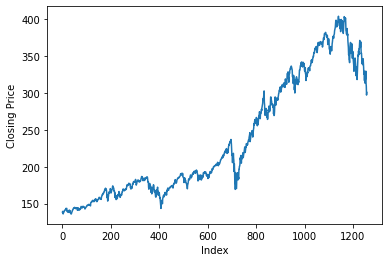

In [9]:
plt.plot(df1)
plt.xlabel('Index')
plt.ylabel('Closing Price')

In [10]:
# LSTM are sensitive to the scale of the data. so we apply MinMax scaler 

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [12]:
df1.shape

(1258, 1)

In [13]:
# Splitting dataset into train and test split
training_size=int(len(df1)*0.67)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [14]:
training_size,test_size

(842, 416)

In [15]:
# convert an array of values into a dataset matrix i.e time series data into supervised learning data
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step)]   # i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step])
	return np.array(dataX), np.array(dataY)

In [16]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [17]:
print(X_train.shape) 
print(y_train.shape)

(741, 100, 1)
(741, 1)


In [18]:
print(X_test.shape)
print(ytest.shape)

(315, 100, 1)
(315, 1)


In [19]:
# Input in the form [samples, time steps, features] which is required for LSTM

In [20]:
print(X_train.shape)
print(X_test.shape)

(741, 100, 1)
(315, 100, 1)


In [21]:
# Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [22]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1))) # It expects to know the shape of inputs
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=2)

In [25]:
import tensorflow as tf

In [26]:
# Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [27]:
# Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [28]:
train_predict.shape

(741, 1)

In [29]:
test_predict.shape

(315, 1)

In [30]:
# Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

192.58719857545867

In [31]:
# Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

340.50637292620826

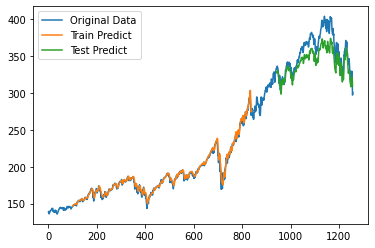

In [32]:
# Plotting and shifting predicted outcomes to match the original test data output
look_back=100
trainPredictPlot = np.empty_like(df1)  # Creates an empty array
trainPredictPlot[:, :] = np.nan # Tells that the values are undefined
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# Plot baseline and predictions
plt.plot(scaler.inverse_transform(df1),label="Original Data")
plt.plot(trainPredictPlot,label="Train Predict")
plt.plot(testPredictPlot,label="Test Predict")
plt.legend()
plt.show()

In [33]:
len(test_data)

416

In [34]:
x_input=test_data[316:].reshape(1,-1) # Row is 1 and columns are unknown
x_input.shape


(1, 100)

In [35]:
temp_input=list(x_input)  # Each input is in the form of list present in an array
temp_input=temp_input[0].tolist() # Converts the array into list

In [36]:
temp_input

[0.9359883547327559,
 0.9287847118542849,
 0.9130337414153478,
 0.9448342788892206,
 0.9625261272021497,
 0.9736115258286056,
 0.9980964467005076,
 0.9911167512690355,
 0.9908928038220364,
 0.9864138548820542,
 0.9770827112570917,
 0.9913780232905345,
 0.9719319199761123,
 0.9264705882352942,
 0.9254628247237979,
 0.9099358017318602,
 0.9108689160943564,
 0.9321812481337712,
 0.9378919080322485,
 0.9017243953418932,
 0.9104956703493579,
 0.8751866228724992,
 0.8599955210510599,
 0.8422290235891312,
 0.8047924753657807,
 0.8108017318602567,
 0.7802329053448791,
 0.7782173783218871,
 0.765265750970439,
 0.8052030456852792,
 0.8471931919976112,
 0.8564123618990742,
 0.8674977605255298,
 0.8117348462227529,
 0.8283816064496863,
 0.8176321289937294,
 0.8325246342191699,
 0.8609286354135564,
 0.8299492385786802,
 0.7875111973723499,
 0.7891161540758436,
 0.8213645864437145,
 0.8210286652732159,
 0.7815019408778738,
 0.7667960585249327,
 0.7539937294714838,
 0.7216706479546133,
 0.76298895192

In [37]:
len(temp_input)

100

In [ ]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)  # Output after previous 100 days of input
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    
print(lst_output)

In [40]:
import matplotlib.pyplot as plt

In [48]:
len(df1)

1258

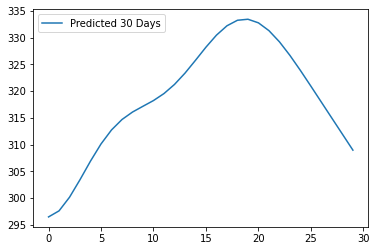

In [49]:
plt.plot(scaler.inverse_transform(lst_output),label='Predicted 30 Days')
plt.legend()

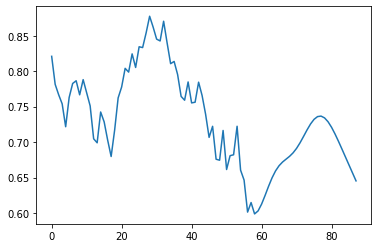

In [47]:
# Complete Output
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [44]:
df3=scaler.inverse_transform(df3).tolist()

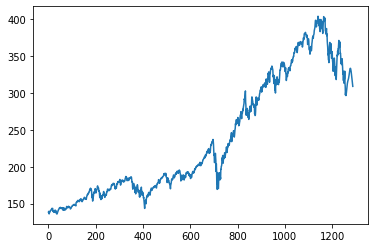

In [45]:
plt.plot(df3)